# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




In [1]:
from IPython.display import Image
import pandas as pd 
import numpy as np
import pylab as pl
import matplotlib.pyplot as pl
from __future__ import print_function, division
import urllib
import datetime
import statsmodels.api as sm
import os
import zipfile
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
#from scipy.spatial.distance import cdist, pdist
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
PUIdata = os.getenv('PUIDATA')

filename = "/MTA_Fare.npy"
url = "https://github.com/fedhere/PUI2017_fb55/raw/master/HW10_fb55/MTA_Fare.npy"

if not os.path.isfile(PUIdata + filename):
    print("Downloading file now & unzipping to PUIdata")
    urllib.urlretrieve(url,PUIdata+filename)
    
    #zip_ref = zipfile.ZipFile(PUIdata+filename, 'r')
    #zip_ref.extractall(PUIdata)
    #zip_ref.close()
    
else: 
    print("File already downloaded & placed in PUIdata")

File already downloaded & placed in PUIdata


In [3]:
#url = "https://github.com/fedhere/PUI2017_fb55/raw/master/HW10_fb55/MTA_Fare.npy"
#urllib.urlretrieve(url, "MTA_Fare.npy")

mtaRides = np.load("MTA_Fare.npy")
print(mtaRides.shape)
mtaRides = mtaRides.astype('float')

mtaRides[mtaRides == -1.0] = np.NaN
#mtaRides[mtaRides == -1.0] = 0

(600, 23, 194)


## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [4]:
# Getting 194 weeks and 23 ticket types 

swipesByWeek = np.nansum(mtaRides, axis=0)
print(swipesByWeek.shape)

swipesByWeek = np.nansum(swipesByWeek, axis=0)
print(swipesByWeek.shape)

print(swipesByWeek)

(23, 194)
(194,)
[ 26720267.  29265971.  29601189.  29387592.  29185768.  26211666.
  28683614.  29125646.  28803814.  28599546.  28312019.  27931015.
  27271701.  28250357.  26687174.  30018756.  30183790.  29052100.
  30068614.  29172431.  30327068.  30190292.  29987273.  30053446.
  30128994.  25164391.  29189219.  30580790.  30106591.  27561217.
  21802973.  21796368.  27483123.  27112540.  26013915.  26433790.
  28660073.  29103923.  29576628.  26721588.  29180204.  29400660.
  29880586.  29677420.  29525360.  30175740.  30196675.  28500091.
  29035465.  30398309.  29992271.  29953470.  27148617.  29850111.
  30165985.  29979266.  30298087.  26744295.  29967687.  29475619.
  29253128.  29429842.  29063294.  27980138.  27924672.  22985008.
  28142943.  31996089.  32506259.  24297825.  32159233.  30747690.
  32641199.  32904387.  31953835.  32131041.  32477470.  27031175.
  31808940.  33123277.  33173847.  31934242.  24565703.  28049643.
  30004428.  28040469.  29387312.  31200600. 

In [5]:
print("Mean:", swipesByWeek.mean())
print("Standard deviation:", swipesByWeek.std())

Mean: 29781349.8711
Standard deviation: 2983960.4217


As a gut logic check, this seems about right -- an average of 30 million rides per week with a standard deviation of 3 million. 

In [6]:
thresholds = [(np.mean(swipesByWeek) + (3 * np.std(swipesByWeek))), 
              (np.mean(swipesByWeek) - (3 * np.std(swipesByWeek)))]
print("Upper Threshold:", thresholds[0], "\n"
      "Lower Threshold:", thresholds[1])

Upper Threshold: 38733231.1362 
Lower Threshold: 20829468.606


In [7]:
date_range = pd.date_range(end="02/14/2014", freq="W", periods=194)

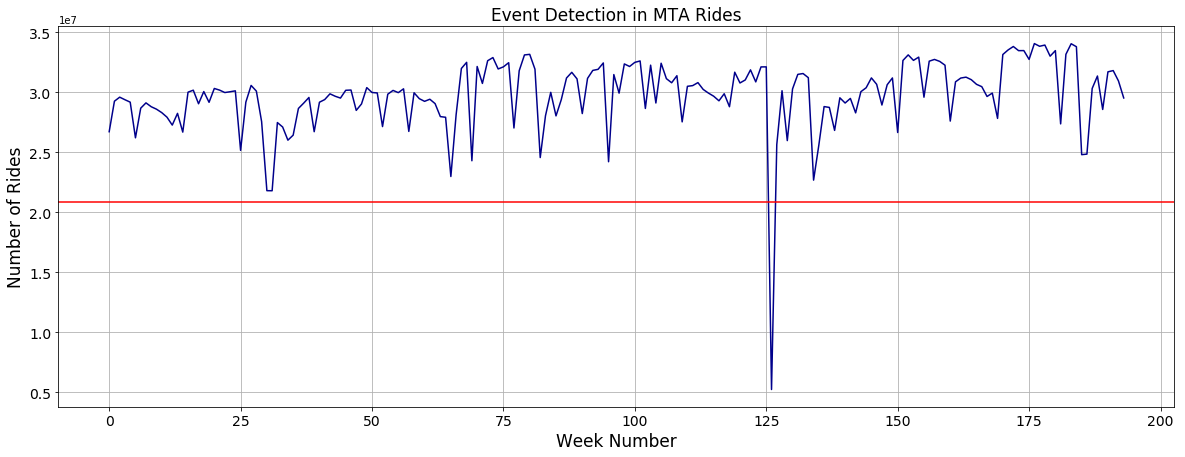

In [8]:
pl.figure(figsize=(20,7))
pl.plot(swipesByWeek, color='darkblue')
pl.axhline(thresholds[1], color='red')
pl.xlabel("Week Number", fontsize=17)
pl.ylabel("Number of Rides", fontsize=17)
pl.title("Event Detection in MTA Rides", fontsize=17)
pl.xticks(fontsize=14)
pl.yticks(fontsize=14)
pl.grid()

#### Fig 1. Looking for an event in 194 weeks of MTA data (swipes per week, per station), it is easy to viusally see there was a major and significant event that plummeted below the threshold (red line). Upon further inspection, it can be found this was the week of Hurricane Sandy (October XX, 2012). The start date is 05/21/2010. The end date is 02/14/2014. 

In [9]:
for i in range(len(swipesByWeek)): 
    if swipesByWeek[i] < thresholds[1]:
        print("The week under the lower threshold is: {}".format(i))

The week under the lower threshold is: 126


In [10]:
#Going from first date 
start_date = datetime.datetime.strptime("05/21/2010","%m/%d/%Y")
event_date = start_date + datetime.timedelta(days=(126*7))
print(event_date)

#Going from last date
end_date = datetime.datetime.strptime("02/21/2014", '%m/%d/%Y')
event_date2 = end_date - datetime.timedelta(days=((194-125)*7))
print(event_date2)

2012-10-19 00:00:00
2012-10-26 00:00:00


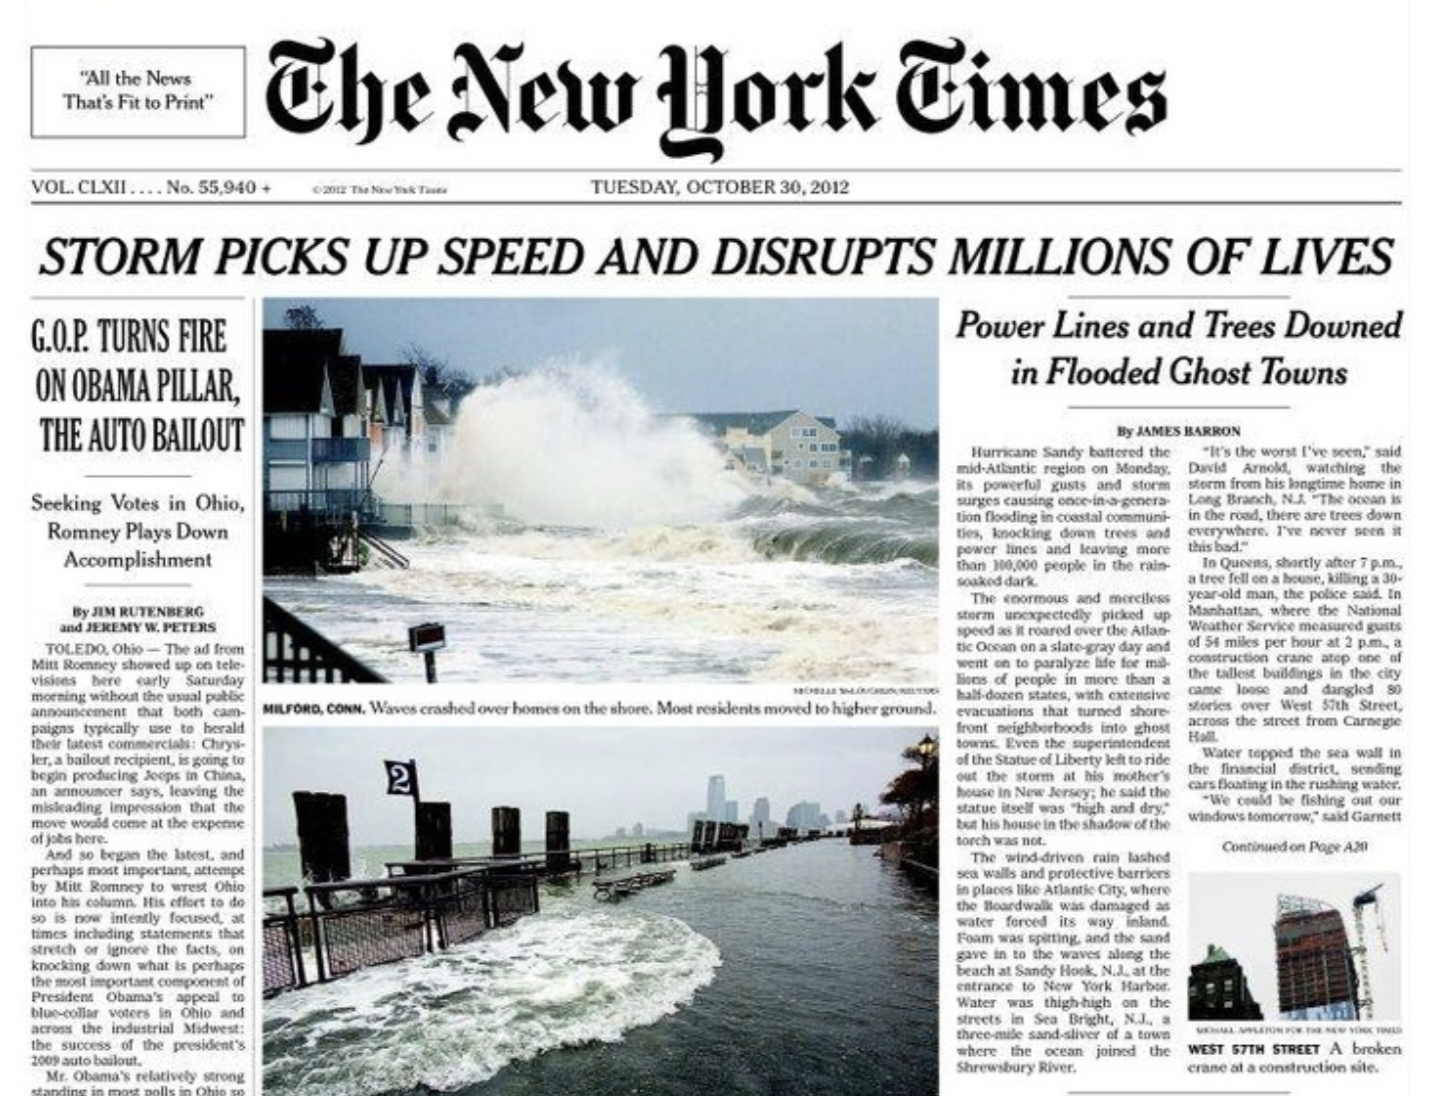

In [11]:
Image(filename='Sandy.png', width=500, height=500)

Hurricane Sandy hit NYC on October 29, 2012, which aligns with the dates from our data. (The data is from 05/21/2010 to 02/21/2014, which is 196 weeks. The data only contains 194 weeks, but it is not readily identified what weeks are missing.) Checking news sources, it is not difficult to find evidence supporting this drop, as the subway was shut for multiple days. 

- "New York City Subways to Shut Down as Sandy Nears" https://www.wsj.com/articles/SB10001424052970204840504578084582421401190

- "Flooded Tunnels May Keep City’s Subway Network Closed for Several Days":  http://www.nytimes.com/2012/10/31/nyregion/subways-may-be-shut-for-several-days-after-hurricane-sandy.html

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

## NOTE ON THE TREND DETECTION:
### you should find the *card type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - np.average(....weight=...) -. The sum and average functions take an axis argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.

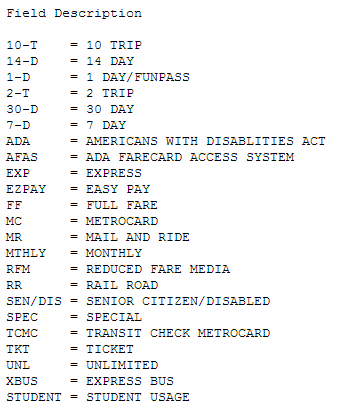

In [12]:
Image(filename = "Ridetypes.png")

In [13]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [14]:
tickets = np.nansum(mtaRides, axis=0)
print(tickets.shape)

(23, 194)


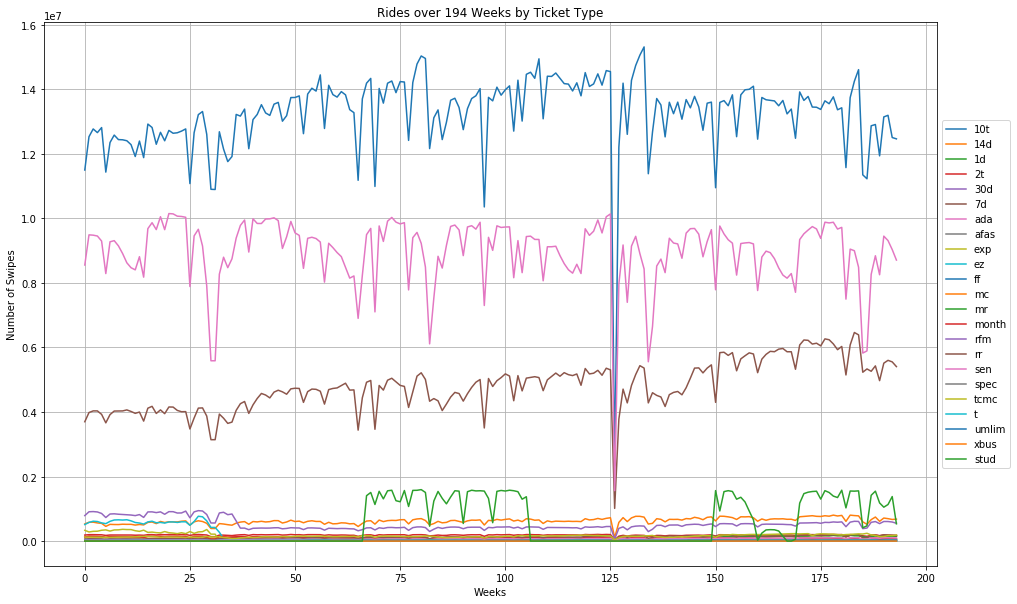

In [15]:
fig = plt.figure(figsize=(16,10))

for i, j in zip(tickets, ridetype): 
    pl.plot(i)
    pl.xlabel("Weeks")
    pl.ylabel("Number of Swipes")
    pl.title("Rides over 194 Weeks by Ticket Type")
    pl.legend(ridetype, loc="center left", bbox_to_anchor=(1,0.5))
    pl.grid()

#### Fig 2. This plot of all swipes by card week across 194 weeks shows that certain card types have increased or decreased in popularity.

In [16]:
first10 = np.array([])
last10 = np.array([])
change10 = np.array([])

for i in range(len(tickets)): 
    #first = pd.rolling_mean(tickets[i][0:10], 10)
    first = np.sum(tickets[i][0:10])
    last = np.sum(tickets[i][184:194])
    change = last / first
    first10 = np.append(first10, first)
    last10 = np.append(last10, last)
    change10 = np.append(change10, change)

In [17]:
df = pd.DataFrame(change10, ridetype)
df.columns = ["change"]
df.sort_values('change', ascending=False)

change
stud            inf
mr     2.478493e+04
spec   7.018238e+01
sen    2.909397e+00
rr     2.592960e+00
xbus   1.662327e+00
tcmc   1.532271e+00
7d     1.389748e+00
14d    1.252065e+00
mc     1.213541e+00
1d     1.111345e+00
30d    1.033787e+00
10t    1.021798e+00
t      1.021589e+00
2t     9.338034e-01
ada    8.998413e-01
ff     8.188021e-01
umlim  8.090639e-01
rfm    6.496084e-01
month  5.787224e-01
afas   2.094470e-04
exp    1.068703e-05
ez     1.501956e-06

From a sorted dataframe, we can see that the biggest increase was the student card. When you check the plot, you can see that student started out at 0, so that logically makes sense. 

From a sorted dataframe, we can see that the biggest decrease was the 'ez' (easy pay). When you check the plot, you can see that around week 30, the card tapers off to 0, indicating the card was discontinued. 

[https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test] Null hypothsis: there is a "unit root": i.e. the series is not stationary [http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html]


From wiki: "The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. **The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence."**

In [18]:
## I tried taking the rolling mean BEFORE making it a df, and that made a whole lot of problems with NaN values. 
## Workaround was to make it a df, then do math of rolling mean. 


station = np.nansum(mtaRides, axis=1)
station = np.nansum(station, axis = 1)
#ticket2 = np.average(mtaRides, axis = 0, weights = station) 
#station.shape

In [19]:
tickets.shape

(23, 194)

In [20]:
dates = pd.date_range(start = "05/21/2010", periods = 194, freq='W-FRI')
dfticket = pd.DataFrame(tickets.T)
dfticket.set_index(dates, inplace=True)
dfticket.columns = ridetype
dfticket.head()

10t       14d       1d        2t      30d         7d  \
2010-05-21  11494615.0  530524.0  47801.0  186551.0  46808.0  3697443.0   
2010-05-28  12526859.0  583533.0  51486.0  199229.0  64353.0  3981808.0   
2010-06-04  12766627.0  586194.0  51636.0  199668.0  56994.0  4033030.0   
2010-06-11  12653675.0  562602.0  52063.0  196389.0  37429.0  4032753.0   
2010-06-18  12809694.0  548858.0  51153.0  194883.0  35210.0  3925446.0   

                  ada     afas       exp        ez  ...      month       rfm  \
2010-05-21  8551937.0  10063.0  333197.0  512032.0  ...   123134.0  790110.0   
2010-05-28  9486394.0  11847.0  282755.0  578023.0  ...   151948.0  908068.0   
2010-06-04  9476538.0  12277.0  302028.0  615537.0  ...   151538.0  914124.0   
2010-06-11  9450081.0  11221.0  305513.0  606270.0  ...   147094.0  902549.0   
2010-06-18  9294002.0  10515.0  335780.0  563446.0  ...   137888.0  855573.0   

                 rr      sen   spec      tcmc        t   umlim   xbus  stud  
2010-05-21  59809.0  28221.0    0.0  124693.0  21060.0  6128.0  358.0   0.0  
2010-05-28  69209.0  32333.0    0.0  121713.0  21670.0  6120.0  474.0   0.0  
2010-06-04  69574.0  32618.0    0.0  122181.0  21433.0  6490.0  465.0   0.0  
2010-06-11  68099.0  32404.0    0.0  122051.0  21630.0  6590.0  484.0   0.0  
2010-06-18  66377.0  31933.0  176.0  119776.0  20297.0  6313.0  452.0   0.0  

[5 rows x 23 columns]

In [21]:
dfticket

10t       14d       1d        2t      30d         7d  \
2010-05-21  11494615.0  530524.0  47801.0  186551.0  46808.0  3697443.0   
2010-05-28  12526859.0  583533.0  51486.0  199229.0  64353.0  3981808.0   
2010-06-04  12766627.0  586194.0  51636.0  199668.0  56994.0  4033030.0   
2010-06-11  12653675.0  562602.0  52063.0  196389.0  37429.0  4032753.0   
2010-06-18  12809694.0  548858.0  51153.0  194883.0  35210.0  3925446.0   
2010-06-25  11429783.0  455691.0  46852.0  175648.0  46849.0  3663144.0   
2010-07-02  12346877.0  518187.0  48963.0  188467.0  60225.0  3918104.0   
2010-07-09  12576759.0  513412.0  49629.0  188090.0  47439.0  4028251.0   
2010-07-16  12437115.0  512192.0  49030.0  186822.0  32084.0  4030717.0   
2010-07-23  12431257.0  522569.0  50376.0  190528.0  52171.0  4032340.0   
2010-07-30  12401572.0  518622.0  48958.0  188840.0  54660.0  4063667.0   
2010-08-06  12280641.0  519691.0  48619.0  187663.0  44183.0  4015534.0   
2010-08-13  11913505.0  496049.0  47465.0  182039.0  29340.0  3957270.0   
2010-08-20  12391812.0  513987.0  50013.0  185601.0  37160.0  3997382.0   
2010-08-27  11878127.0  500940.0  47675.0  179293.0  45464.0  3716943.0   
2010-09-03  12918455.0  578854.0  51176.0  197971.0  61920.0  4116973.0   
2010-09-10  12812272.0  590931.0  51707.0  200593.0  45491.0  4174242.0   
2010-09-17  12292468.0  541989.0  49344.0  189592.0  36554.0  3954011.0   
2010-09-24  12662413.0  608230.0  52702.0  205199.0  63071.0  4064042.0   
2010-10-01  12400611.0  575635.0  49929.0  197285.0  59699.0  3947496.0   
2010-10-08  12721967.0  598850.0  51861.0  202933.0  50235.0  4154100.0   
2010-10-15  12633600.0  594344.0  50945.0  202221.0  33666.0  4151499.0   
2010-10-22  12648413.0  593408.0  51321.0  202022.0  60117.0  4048087.0   
2010-10-29  12699903.0  615322.0  51993.0  202611.0  61981.0  4007502.0   
2010-11-05  12767910.0  626051.0  52094.0  205518.0  55200.0  4010508.0   
2010-11-12  11074280.0  493810.0  44479.0  176420.0  24627.0  3473064.0   
2010-11-19  12651006.0  596919.0  50745.0  199127.0  47185.0  3812625.0   
2010-11-26  13210412.0  629121.0  51972.0  204945.0  64080.0  4119030.0   
2010-12-03  13306773.0  606671.0  50345.0  196107.0  59255.0  4125508.0   
2010-12-10  12600160.0  551093.0  48429.0  188623.0  30367.0  3872145.0   
...                ...       ...      ...       ...      ...        ...   
2013-07-12  13635157.0  689994.0  58094.0  187054.0  45927.0  5866520.0   
2013-07-19  13485019.0  686705.0  60128.0  188823.0  56981.0  5945813.0   
2013-07-26  13649267.0  691105.0  58146.0  189038.0  53423.0  5966736.0   
2013-08-02  13233130.0  675279.0  58245.0  187292.0  42113.0  5864963.0   
2013-08-09  13382775.0  676254.0  58066.0  187404.0  35728.0  5865129.0   
2013-08-16  12477834.0  639655.0  56320.0  176015.0  45463.0  5322521.0   
2013-08-23  13913373.0  753222.0  60480.0  198868.0  64786.0  6074971.0   
2013-08-30  13651157.0  763619.0  62470.0  202085.0  57804.0  6229329.0   
2013-09-06  13773146.0  773510.0  61994.0  201775.0  46068.0  6219136.0   
2013-09-13  13445117.0  785884.0  64678.0  203151.0  57841.0  6103608.0   
2013-09-20  13439745.0  767620.0  64506.0  202091.0  65573.0  6129867.0   
2013-09-27  13372173.0  762925.0  62803.0  198412.0  54819.0  6047366.0   
2013-10-04  13637610.0  785163.0  63636.0  205711.0  49184.0  6263875.0   
2013-10-11  13548111.0  771250.0  63003.0  203160.0  46893.0  6237441.0   
2013-10-18  13761191.0  804458.0  66519.0  206175.0  65481.0  6107842.0   
2013-10-25  13360751.0  777877.0  62685.0  200040.0  63239.0  5929342.0   
2013-11-01  13422367.0  795525.0  63711.0  203081.0  54939.0  6029517.0   
2013-11-08  11569460.0  610528.0  52416.0  170706.0  30535.0  5146488.0   
2013-11-15  13736112.0  803871.0  65193.0  200552.0  64277.0  6074119.0   
2013-11-22  14244936.0  790419.0  64417.0  197882.0  67490.0  6461735.0   
2013-11-29  14604028.0  781529.0  62658.0  193268.0  56671.0  6388538.0   
2013-12-06  11344945.0  596341.0  50820.0  1

In [22]:
dfticket.shape

(194, 23)

In [23]:
## I then tried to take the rolling mean of the df with np.average, but of course that didn't work (duh), 
## because it is no longer a numpy array. So I googled "take rolling mean of dataframe" and found 
## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html 

#station = np.nansum(mtaRides, axis=1)
#station = np.nansum(station, axis = 1)

mean = dfticket.rolling(window=10, center=False, axis=0).mean()

In [24]:
#ticketroll = []

#for i in dfticket.columns:
    #ticketroll.append(pd.rolling_mean(dfticket[i], 10))

In [25]:
#dfticketmean = pd.DataFrame(ticketroll).T

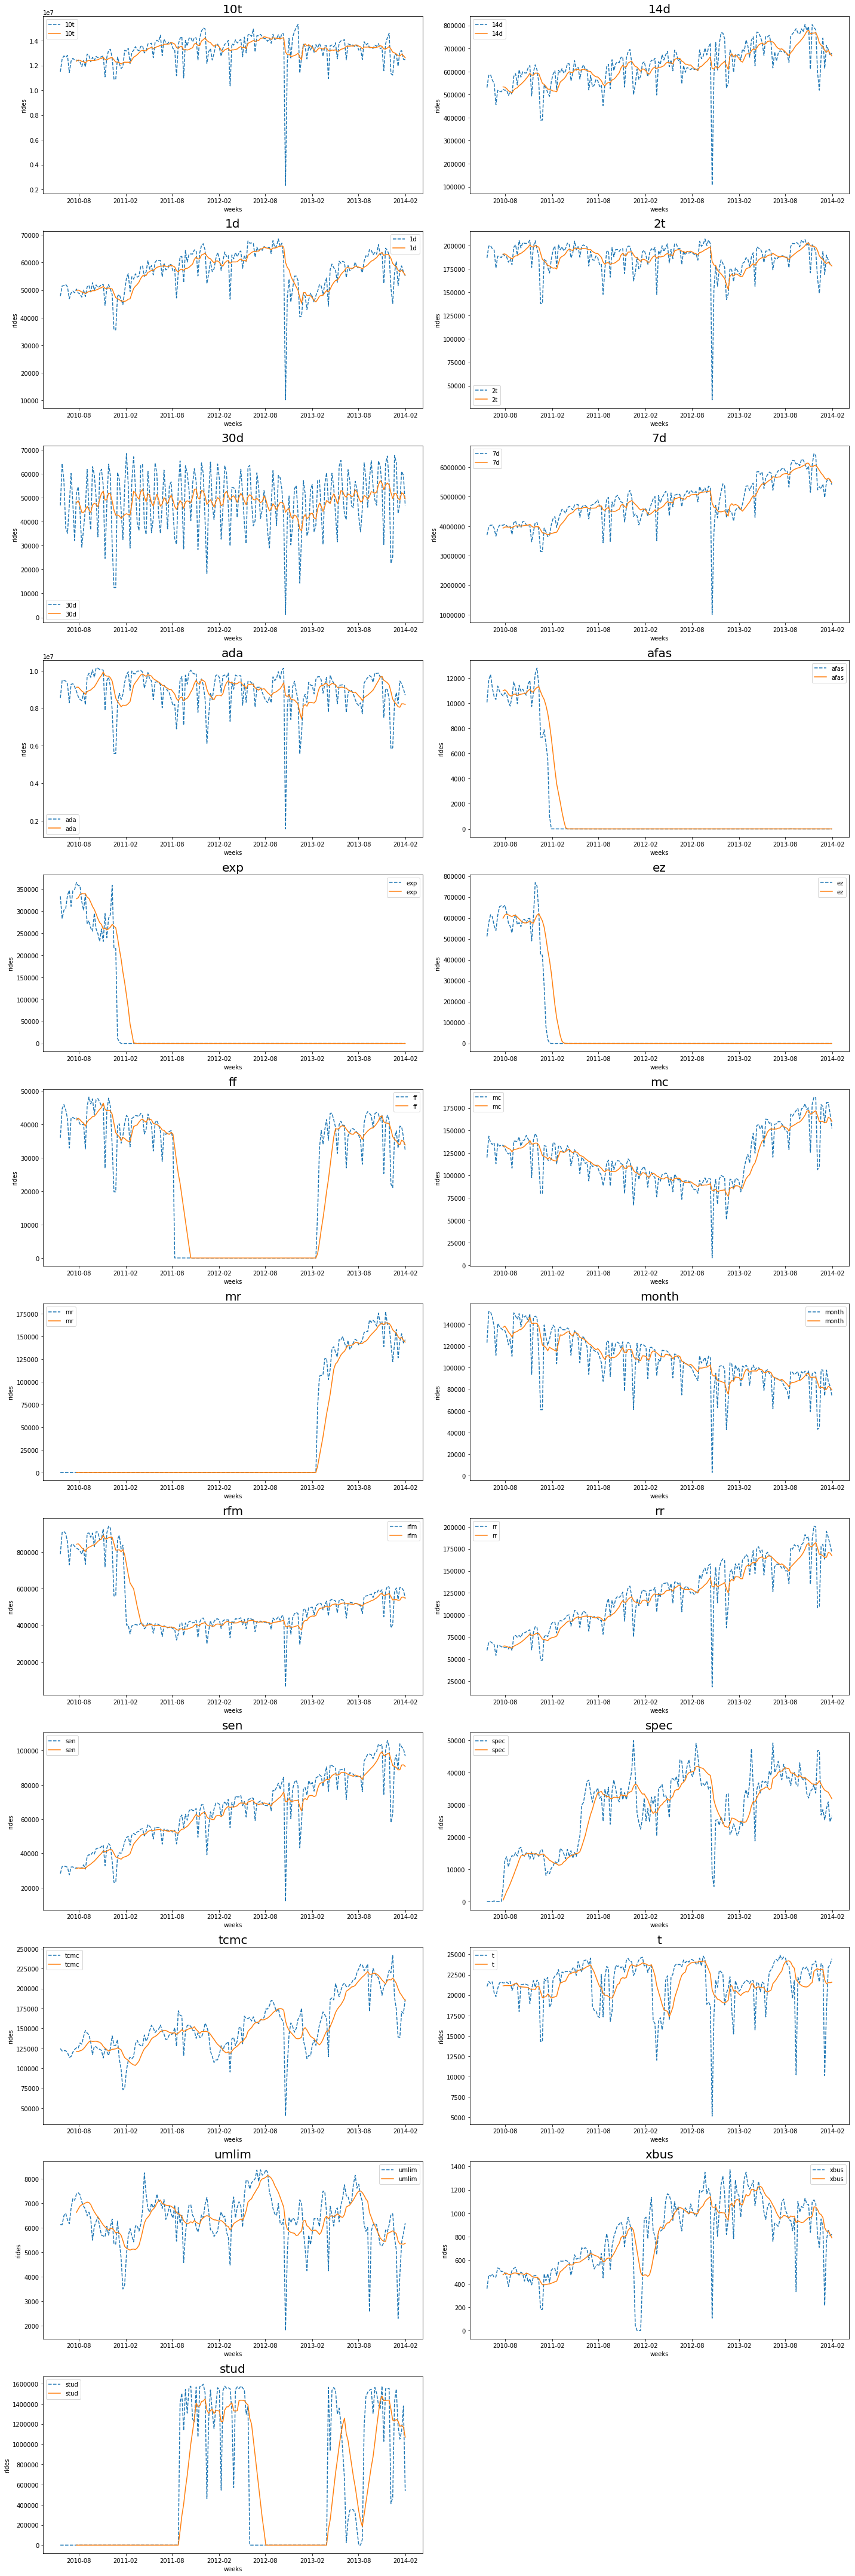

In [26]:
fig = pl.figure(figsize=(20,60))

for i in range(len(dfticket.columns)): 
    pl.subplot(12,2,i+1)
    pl.plot(dfticket.iloc[:,i], "--")
    pl.plot(mean.iloc[:,i])
    pl.title(dfticket.columns[i], fontsize = 20)
    pl.xlabel("weeks")
    pl.ylabel("rides")
    pl.legend()
    
pl.tight_layout()
pl.show()

##### Fig. The plots above show the rolling mean as compared to the average mean, for each the number of swipes by ticket type, across all stations for 194 weeks. 

In [27]:
stationary = []
nonstationary = []

for i in range(len(dfticket.columns)): 
    statTest = sm.tsa.adfuller(dfticket.iloc[:,i])
    if (statTest[0] > statTest[4]['5%']): 
        nonstationary.append(dfticket.columns[i])
    else: 
        stationary.append(dfticket.columns[i])

print("AD Fuller test results")
print(stationary)
print(nonstationary)

AD Fuller test results
['10t', '2t', '30d', 'ada', 'exp', 'tcmc', 't', 'umlim']
['14d', '1d', '7d', 'afas', 'ez', 'ff', 'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'xbus', 'stud']


In [28]:
sm.tsa.adfuller(dfticket.iloc[3])

(-4.2177354425424687,
 0.00061480330262091078,
 8,
 14,
 {'1%': -4.0120336005830897,
  '10%': -2.6909873469387753,
  '5%': -3.1041838775510207},
 327.77215300498909)

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [29]:
#stations2 = np.nansum(mtaRides, axis=1)
#stations2 = np.nansum(stations2, axis=1)
#stations2.shape

In [30]:
stations2 = np.nansum(mtaRides, axis=1)
print(stations2.shape)

(600, 194)


In [31]:
stat_name = np.arange(0,600)
#stat_name

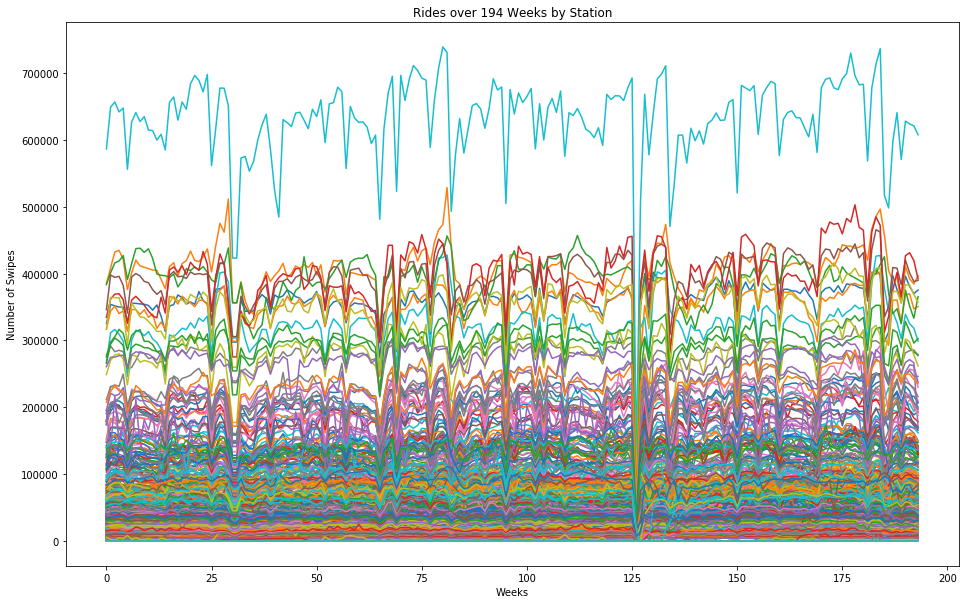

In [32]:
fig = plt.figure(figsize=(16,10))

for i, j in zip(stations2, stat_name): 
    pl.plot(i)
    pl.xlabel("Weeks")
    pl.ylabel("Number of Swipes")
    pl.title("Rides over 194 Weeks by Station")

##### Fig 4 This is a plot of the number of swipes per station, across all card types, for 194 weeks. 

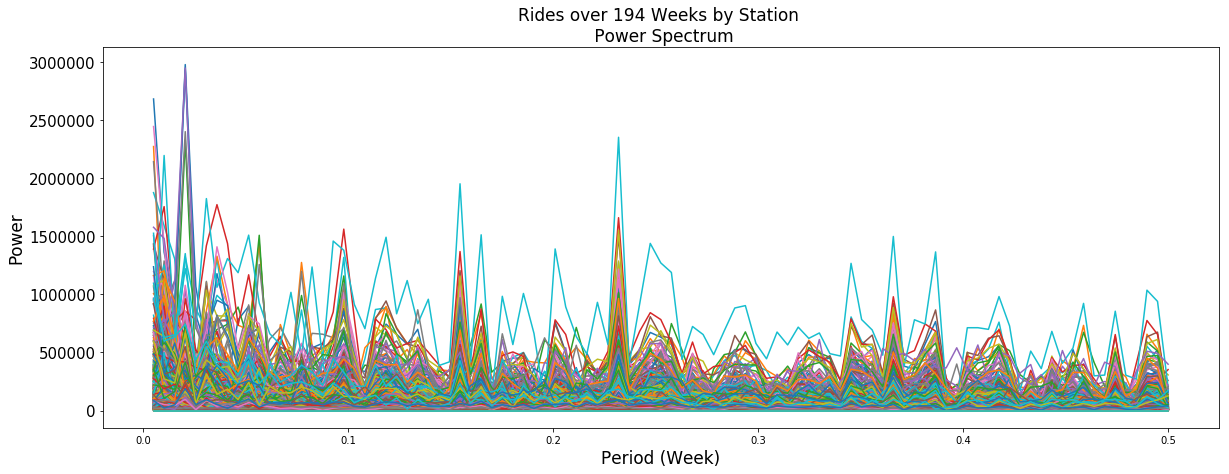

In [33]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
N = len(range(194))

for i in range(600):
    f = np.abs(np.fft.rfft(stations2[i]))
    ax.plot(np.fft.rfftfreq(N, 1)[1:], (f)[1:], '-')
    pl.xlabel("Period (Week)", fontsize=17)
    pl.ylabel("Power", fontsize=17)
    pl.title("Rides over 194 Weeks by Station \n Power Spectrum", fontsize=17)
    pl.yticks(fontsize=15)

Fig 5. Power Spectrum of swipes per week by station 

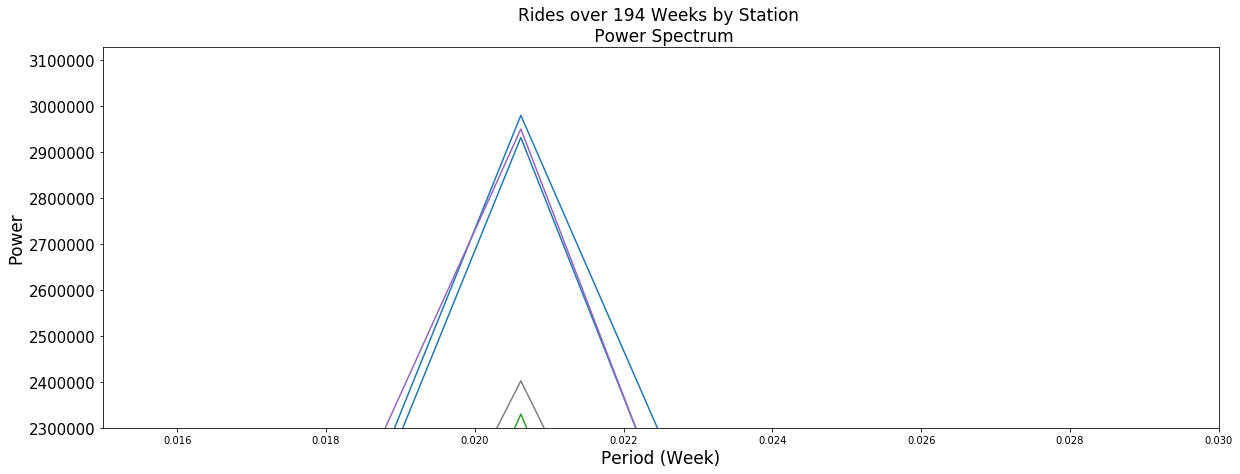

In [34]:
fig = plt.figure(figsize=(20,7))
ax=fig.add_subplot(111)
N = len(range(194))

for i in range(600):
    f = np.abs(np.fft.rfft(stations2[i]))
    ax.plot(np.fft.rfftfreq(N, 1)[1:], (f)[1:], '-')
    pl.xlabel("Period (Week)", fontsize=17)
    pl.ylabel("Power", fontsize=17)
    pl.title("Rides over 194 Weeks by Station \n Power Spectrum", fontsize=17)
    pl.yticks(fontsize=15)
    pl.xlim(0.015, 0.03)
    pl.ylim(2300000)

Fig 6. This is a zoomed in version of Fig 5 to show the peaks. 

In [35]:
len(np.abs(np.fft.rfft(stations2[599])))

98

In [36]:
(196/4)*2

98.0

In [37]:
peaks = []

for i in range(600):
    f = np.abs(np.fft.rfft(stations2[i]))
    if f[4] > 2330000:
        peaks.append(i)

In [38]:
print("The stations with biggest annual peaks are:", peaks)

The stations with biggest annual peaks are: [0, 150, 194, 327]


To find the filtering numbers for both the plot and for loop, I started with 2000000 for the y and kept increasing it more and more incrementally until it it was showing just the tops. I similarly played around with the x axis limit. 

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [39]:
tots = mtaRides.transpose(2,0,1).reshape(mtaRides.shape[2], mtaRides.shape[1]*mtaRides.shape[0]).T
tot = tots[std(1)>0]
KMeans(n_clusters=10)
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a boolean instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [40]:
tots = mtaRides.transpose(2,0,1).reshape(mtaRides.shape[2], 
                                         mtaRides.shape[1]*mtaRides.shape[0]).T

In [41]:
tots = tots[tots.std(1)>0]

In [42]:
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

In [43]:
n = 3
pca = PCA(n)
X = pca.fit_transform(vals)

In [44]:
#X=np.asarray(vals[:,:-1])

#Guessing a range for N 
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters = n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.456636669608
For n_clusters = 3 The average silhouette_score is : 0.4393137749
For n_clusters = 4 The average silhouette_score is : 0.466527611498
For n_clusters = 5 The average silhouette_score is : 0.443816751141
For n_clusters = 6 The average silhouette_score is : 0.443688202318
For n_clusters = 7 The average silhouette_score is : 0.467511441615
For n_clusters = 8 The average silhouette_score is : 0.466196550864
For n_clusters = 9 The average silhouette_score is : 0.446006721193
For n_clusters = 10 The average silhouette_score is : 0.440871214121


The silhoutte scores show that 7 is the optimal number of clusters. 

In [45]:
clusterer = KMeans(n_clusters = 7)
cluster_labels = clusterer.fit_predict(X)

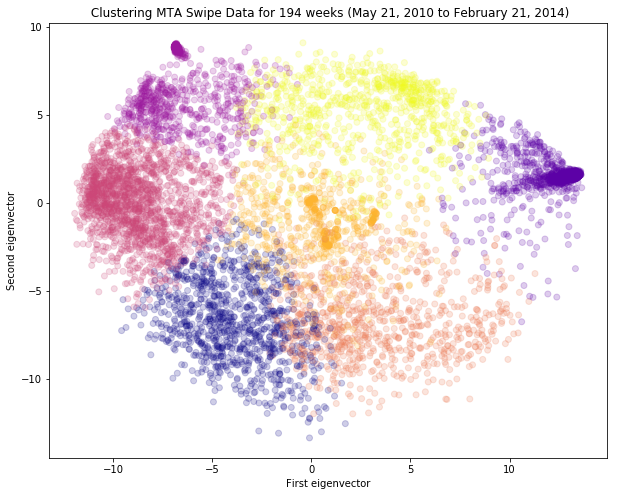

In [46]:
plt.figure(2, figsize=(10,8))
plt.clf()

plt.scatter(X[:,0], X[:,1], c = cluster_labels, cmap = plt.cm.plasma, alpha = 0.2)
plt.title(" Clustering MTA Swipe Data for 194 weeks (May 21, 2010 to February 21, 2014)")
plt.xlabel("First eigenvector")
plt.ylabel("Second eigenvector")
plt.show()

Fig. Clusters of mta ride data for 194 weeks. 7 clusters are presented here, based on the silhouette scores. 


# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft()  

```
np.fft.rfft(mydata) 
```  

      will return the *real* part of the fourier transform (the fourier transform is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math; all you need to know is that you need the real part). But what you want is its absolute value: np.abs(). 
      To plot the fourier transform you may want the x-axis to be in frequency. To get the x-axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

*  after you operate on the array to collapse an axis, always check the dimensionality to assure you have indeed collapsed the right axis! see cell below

```
import numpy as np
data = np.random.rand(100,10)

print(data.shape)
Out[12]: (100, 10)

print(data.mean())
Out[13]:  0.4902457782

print(data.mean(axis=0).shape, data.mean(axis=1).shape)
Out[14]: (10,) (100,)

```

In [47]:
#after reading the datacube you should see:
mtaRides.shape


(600, 23, 194)

ride types list

In [48]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [49]:
#after that I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

In [50]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mtaRide.shape)
mta_allsum = np.nansum(mtaRides, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum = np.nansum(mtaRides, axis=1)
print (mta_allsum.shape)



NameError: name 'mtaRide' is not defined

## NOTE ON THE TREND DETECTION:
### you should find the *card type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

In [ ]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks

In [ ]:
# this is a "power spectrum": the plot of the absolute value of the fourier transform. 
# I changed the xtick labels from frequecy (1/week) to period (in weeks)
# to facilitate the visual identification of the 1-year period peak
# (notice however that np.fft.rfftfreq(N, d)  returns frequency, the inverse of the period: frequency = 1/period. 
# All I did was changing the tick labels): 

...
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90)

In [ ]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space

## ASH Score 100. Extra Credit 100